# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data
Here I import the traffic sign that will be used in the project. The data are splitted in training data, validation data and test data. In this section I also check that the number of features in each set matches the number of labels.

In [1]:
# Load pickled data
import pickle

training_file = "traffic-signs-data/train.p"
validation_file = "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
import csv

def first2(s):
    return s[:2]

with open('signnames.csv', 'r') as f:
    last_csv_line = ','.join(list(csv.reader(f))[-1])
    last_class_num = first2(last_csv_line)

n_classes = int(last_class_num) + 1 #Start counting from zero

print("Number of training examples =", n_train)
print("Number of validatin examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validatin examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

In [3]:
#Given the sign label I want to obtain the corresponding sign description

def find_sign_description(sign_label):
    for i in range(n_classes+1):
        if i == 0:
            continue #skip the first line since it is not describing a traffic sign
            
        with open('signnames.csv', 'r') as f:
            current_csv_line = ','.join(list(csv.reader(f))[i])
            first_two_elem_of_line = first2(current_csv_line)
            if ',' in first_two_elem_of_line: #if we find a comma in the first two elem of the line we delete it
                first_two_elem_of_line = first_two_elem_of_line[0]
            if first_two_elem_of_line == str(sign_label):
                return current_csv_line[2:]
    

In [4]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


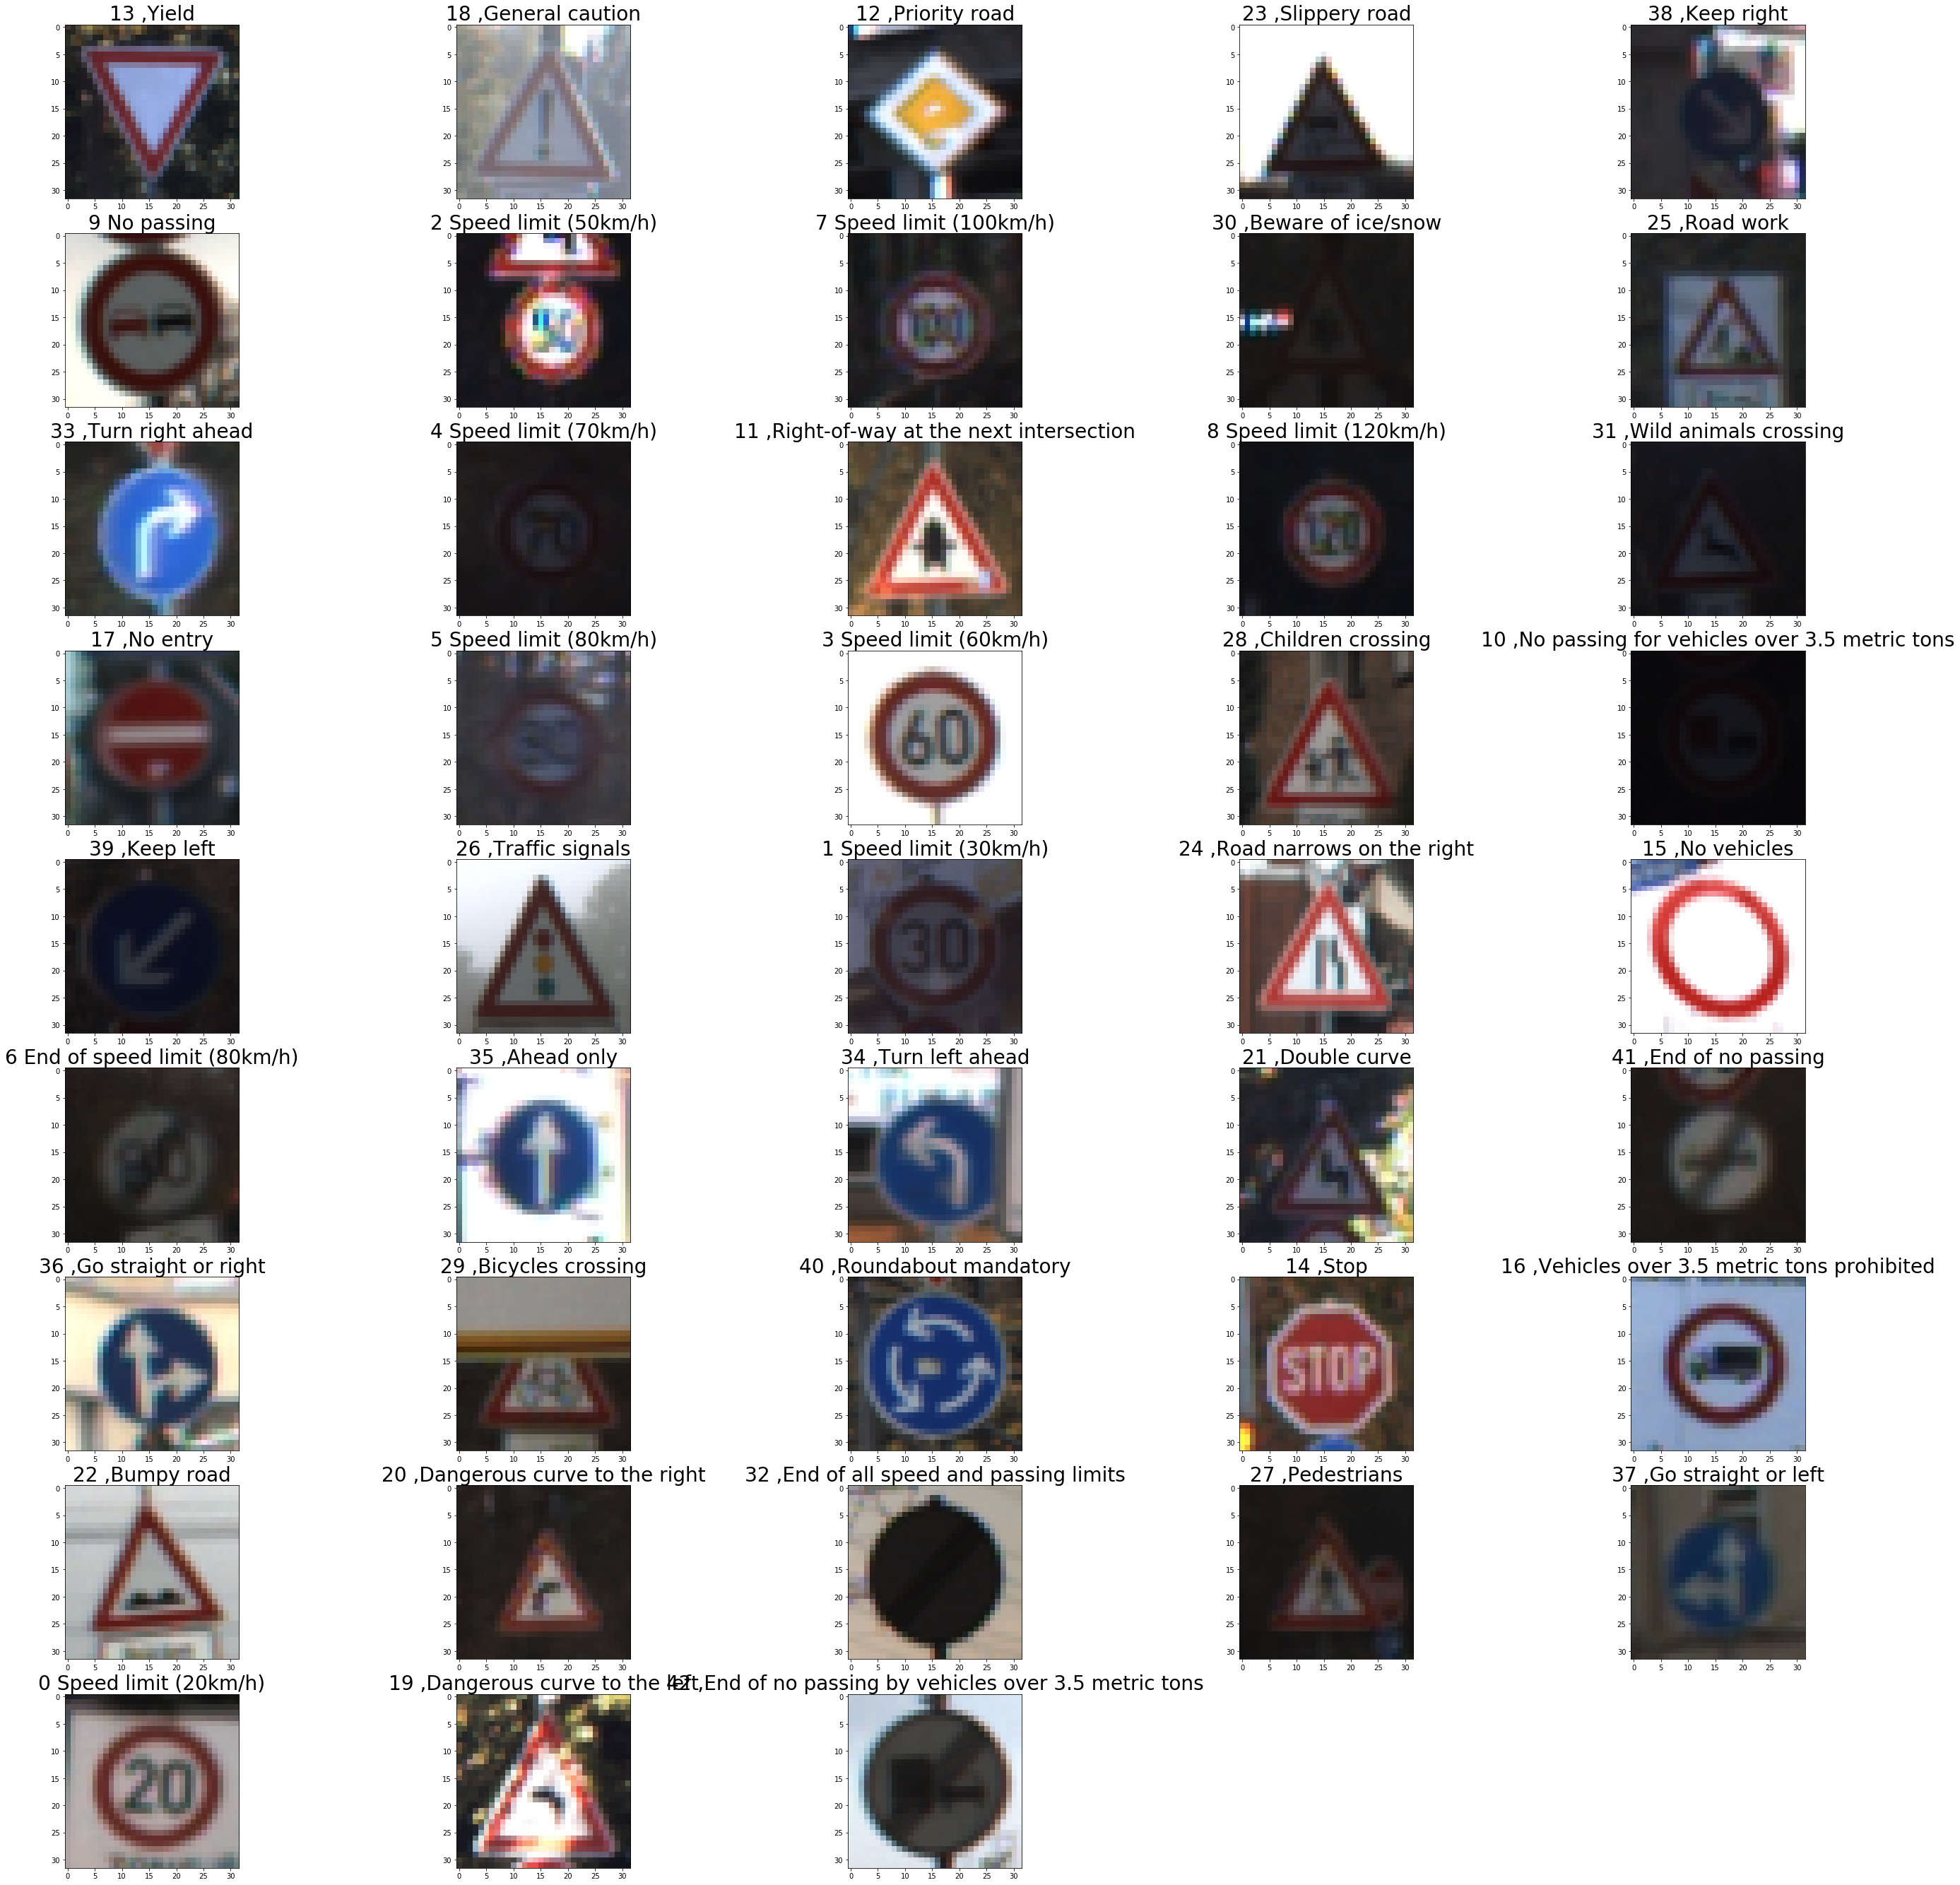

In [5]:
#Shuffle the data to see if at each run of this cell there is correspondence between img and label

X_train, y_train = shuffle(X_train, y_train)

labels_vec = []
count = 1

plt.figure(1, figsize=(48,48))
for img_ind in range(len(X_train)):
    img = X_train[img_ind].squeeze()
    label_img = y_train[img_ind]
    if not (label_img in labels_vec):
        labels_vec.append(label_img)
        plt.subplot(9, 5, count)
        plt.title(str(label_img)+' '+str(find_sign_description(label_img)), fontsize=28)
        plt.imshow(img)
        count = count +1


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

In [6]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.

##Normalization of all the images
def data_normalization(data):
    data = (data-128.)/128.
    return data

X_train = data_normalization(X_train)
X_valid = data_normalization(X_valid)
X_test = data_normalization(X_test)

### Model Architecture

In [7]:
### Define your architecture here.
import tensorflow as tf
from tensorflow.contrib.layers import flatten
keep_prob = tf.placeholder(tf.float32)

def signs_recognitions(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1 = tf.nn.dropout(conv1, keep_prob)

    #Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)


    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob)

    #Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    #Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

EPOCHS = 25
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [9]:
rate = 0.001

logits = signs_recognitions(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [10]:
prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.85})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './sign_recognition')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.730

EPOCH 2 ...
Validation Accuracy = 0.836

EPOCH 3 ...
Validation Accuracy = 0.884

EPOCH 4 ...
Validation Accuracy = 0.903

EPOCH 5 ...
Validation Accuracy = 0.908

EPOCH 6 ...
Validation Accuracy = 0.910

EPOCH 7 ...
Validation Accuracy = 0.929

EPOCH 8 ...
Validation Accuracy = 0.928

EPOCH 9 ...
Validation Accuracy = 0.920

EPOCH 10 ...
Validation Accuracy = 0.918

EPOCH 11 ...
Validation Accuracy = 0.927

EPOCH 12 ...
Validation Accuracy = 0.936

EPOCH 13 ...
Validation Accuracy = 0.934

EPOCH 14 ...
Validation Accuracy = 0.937

EPOCH 15 ...
Validation Accuracy = 0.939

EPOCH 16 ...
Validation Accuracy = 0.942

EPOCH 17 ...
Validation Accuracy = 0.940

EPOCH 18 ...
Validation Accuracy = 0.943

EPOCH 19 ...
Validation Accuracy = 0.941

EPOCH 20 ...
Validation Accuracy = 0.940

EPOCH 21 ...
Validation Accuracy = 0.937

EPOCH 22 ...
Validation Accuracy = 0.940

EPOCH 23 ...
Validation Accuracy = 0.949

EPOCH 24 ...
Validation Accura

In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    print("\n  Training set accuracy = {:.3f}".format(evaluate(X_train, y_train)))
    print("Validation set accuracy = {:.3f}".format(evaluate(X_valid, y_valid)))
    print("      Test set accuracy = {:.3f}".format(evaluate(X_test, y_test)))

INFO:tensorflow:Restoring parameters from ./sign_recognition

  Training set accuracy = 0.997
Validation set accuracy = 0.941
      Test set accuracy = 0.944


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

In [13]:
### Load the images and plot them here.
import matplotlib.image as mpimg

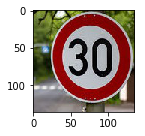

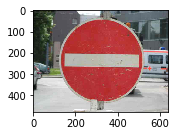

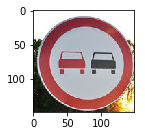

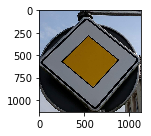

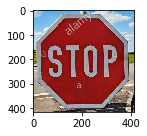

In [14]:
#Append all the images to a list and define a function to plot them 

traffic_signs_images = []
speed_limit_img = mpimg.imread('five_images_example/30Km_h.jpg')
traffic_signs_images.append(speed_limit_img)

not_enter_img = mpimg.imread('five_images_example/Do-Not-Enter.jpg')
traffic_signs_images.append(not_enter_img)

no_passing_img = mpimg.imread('five_images_example/no-passing.jpg')
traffic_signs_images.append(no_passing_img)

priority_img = mpimg.imread('five_images_example/Priority.jpg')
traffic_signs_images.append(priority_img)

stop_img = mpimg.imread('five_images_example/stop.jpg')
traffic_signs_images.append(stop_img)

def plot_signs(img, img_index=0):
    f = plt.figure(img_index)
    f, (ax1) = plt.subplots(1, figsize=(5, 2))
    f.tight_layout()
    ax1.imshow(img)
    return f

for current_image in traffic_signs_images:
    plot_signs(current_image)

### Predict the Sign Type for Each Image

In [15]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
import cv2

#New images preprocessing
# 1 - Convert the images to 32x32
# 2 - Normalize each image as done for the other images

new_img_size = (32, 32) #(width, height)

normalized_images = []
for current_image in traffic_signs_images:
    resized_img = cv2.resize(current_image, new_img_size, interpolation = cv2.INTER_AREA)
    normalized_img = data_normalization(resized_img)
    normalized_images.append(normalized_img)

#Run the prediction 
x_test = normalized_images
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions_output = sess.run(prediction, feed_dict={x: x_test, keep_prob: 1.0})

for current_prediction in predictions_output:
    current_description = find_sign_description(current_prediction)
    print(str(current_prediction) + ' ----> ' + current_description)

INFO:tensorflow:Restoring parameters from ./sign_recognition
1 ----> Speed limit (30km/h)
17 ----> ,No entry
9 ----> No passing
12 ----> ,Priority road
14 ----> ,Stop


### Analyze Performance

In [16]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

#Define ordered ground-thruth labels to compute the accuracy on the new test images

y_test = [1, 17, 9, 12, 14]

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))  
    print("\n  New set accuracy = {:.3f}".format(evaluate(x_test, y_test)))
    
###Running the accuracy calculation on the new images showed all the time accuracy equal to 1.0 or in some cases
###only one image was failing reducing the accuracy to 0.8

INFO:tensorflow:Restoring parameters from ./sign_recognition

  New set accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [17]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
import numpy as np

softmax = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmaxes = sess.run(tf.nn.top_k(softmax, k=5), feed_dict = {x: x_test, keep_prob: 1.0})
    np.set_printoptions(precision=3)
    print(softmaxes)

INFO:tensorflow:Restoring parameters from ./sign_recognition
TopKV2(values=array([[  9.987e-01,   1.259e-03,   6.669e-05,   2.977e-07,   1.661e-08],
       [  1.000e+00,   1.846e-09,   2.114e-12,   1.852e-12,   2.275e-13],
       [  9.998e-01,   1.764e-04,   5.203e-05,   5.134e-06,   2.142e-06],
       [  1.000e+00,   1.649e-07,   1.900e-08,   1.343e-08,   1.119e-08],
       [  9.999e-01,   9.308e-05,   1.382e-05,   8.628e-06,   3.666e-06]], dtype=float32), indices=array([[ 1,  2,  0,  5, 31],
       [17, 14,  9,  0,  1],
       [ 9, 10, 41, 23, 20],
       [12, 29, 42,  9, 13],
       [14,  1, 29, 25,  5]], dtype=int32))
